In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from torch.utils.data import DataLoader ,Dataset
import numpy as np 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import heapq





In [4]:
T2D_f = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_fuctional.csv",sep=",")
T2D_tax = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_taxo.csv",sep=",")
T2D_gen = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_gen40.csv",sep=",")
T2D_labels = pd.read_csv("../Data/Microbiome_data/T2D_data/T2D_ylab.txt")
T2D_labels= T2D_labels.iloc[:-1]
T2D_labels = T2D_labels[:].values
T2D_labels= pd.DataFrame(T2D_labels)
T2D_labels = T2D_labels.replace({"Control": 1, "T2D": 0})

CRC_f = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_Fuctional.csv",sep=",")
CRC_tax = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_Taxo.csv",sep=",")
CRC_gen = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_gen40.csv",sep=",")
CRC_labels = pd.read_csv("../Data/Microbiome_data/CRC_data/CRC_ylab.txt")
CRC_labels= CRC_labels.iloc[:-1]
CRC_labels = CRC_labels[:].values
CRC_labels= pd.DataFrame(CRC_labels)
CRC_labels = CRC_labels.replace({"control": 1, "CRC": 2})

IBD_f = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_fuctional.csv",sep=",")
IBD_tax = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_taxo.csv",sep=",")
IBD_gen = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_gen40.csv",sep=",")
IBD_labels = pd.read_csv("../Data/Microbiome_data/IBD_data/IBD_ylab.txt")
IBD_labels= IBD_labels.iloc[:-1]
IBD_labels = IBD_labels[:].values
IBD_labels= pd.DataFrame(IBD_labels)
IBD_labels = IBD_labels.replace({"Normal": 1, "IBD": 3})


LC_f = pd.read_csv("../Data/Microbiome_data/LC_data/LC_Fuctional.csv",sep=",")
LC_tax = pd.read_csv("../Data/Microbiome_data/LC_data/LC_taxo.csv",sep=",")
LC_gen = pd.read_csv("../Data/Microbiome_data/LC_data/LC_gen40.csv",sep=",")
LC_labels = pd.read_csv("../Data/Microbiome_data/LC_data/LC_ylab.txt")
LC_labels= LC_labels.iloc[:-1]
LC_labels = LC_labels[:].values
LC_labels= pd.DataFrame(LC_labels)
LC_labels = LC_labels.replace({"Normal": 1, "Cirrhosis": 4})


In [5]:
f1 = torch.tensor(T2D_f.values)
f2 = torch.tensor(T2D_gen.values)
f3 = torch.tensor(T2D_tax.values)
f4 = torch.tensor(IBD_f.values)
f5 = torch.tensor(IBD_gen.values)
f6 = torch.tensor(IBD_tax.values)
f7= torch.tensor(CRC_f.values)
f8 = torch.tensor(CRC_gen.values)
f9= torch.tensor(CRC_tax.values)
f10 = torch.tensor(LC_f.values)
f11= torch.tensor(LC_gen.values)
f12 = torch.tensor(LC_tax.values)

l1 = torch.tensor(T2D_labels.values)
l2 = torch.tensor(IBD_labels.values)
l3 = torch.tensor(CRC_labels.values)
l4 = torch.tensor(LC_labels.values)


In [6]:
T2D_comb = torch.cat((f1,f2,f3), dim=1)
IBD_comb = torch.cat((f4,f5,f6), dim=1)
CRC_comb = torch.cat((f7,f8,f9), dim=1)
LC_comb = torch.cat((f10,f11,f12), dim=1)
compined = torch.cat((T2D_comb,IBD_comb,CRC_comb,LC_comb))

labels_combined = torch.cat((l1,l2,l3,l4))

Test1 = torch.cat((f2,f8,f11))
TestL= torch.cat((l1,l3,l4))

In [7]:
#Save it to tensor .pt objects
torch.save(TestL, '../Data/Tensors_objs/labels.pt')
torch.save(Test1, '../Data/Tensors_objs/features.pt')
np.savetxt("test",Test1,delimiter =",")
np.savetxt("TestL",TestL,delimiter=",")
np.savetxt("Data", compined, delimiter=",")
np.savetxt("Labels", labels_combined, delimiter=",")


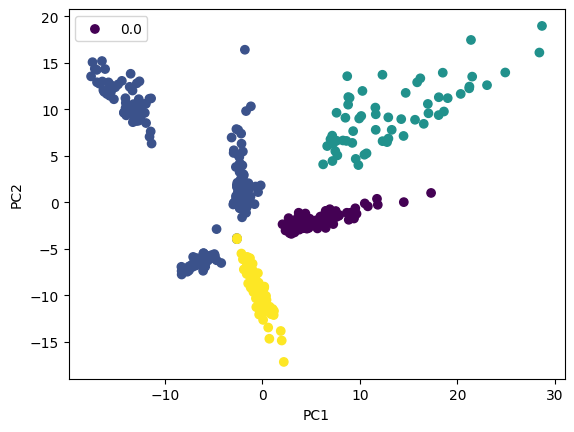

In [6]:


# Load your data into a numpy array called X
X = np.loadtxt("test", delimiter=",")
y = np.loadtxt("TestL")

# Separate your class labels from your feature data


# Apply PCA to reduce the dimensionality of your data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot your data in 2 dimensions, colored by class label
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.legend(y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [10]:
# Load the microbiome data and labels into PyTorch tensors
data = torch.load("../Data/Tensors_objs/features.pt")
labels = torch.load("../Data/Tensors_objs/labels.pt")
data = torch.DoubleTensor(data)
labels = labels.float()
labels = labels.double()
#labels = torch.DoubleTensor(labels)
nan_indices = torch.isnan(data)
data = torch.where(nan_indices, torch.tensor(0.0), data)


dataset = torch.utils.data.TensorDataset(data, labels)
# Define the dataset and dataloader
dataloader = DataLoader(dataset, batch_size=128)

In [11]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'labels': self.labels[idx]}
        return sample

# Define the encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc2(x)
        logvar = self.fc3(x)
        return mu, logvar

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, input_size)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

# Define the loss function
def loss_function(x_hat, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Set the hyperparameters
batch_size = 128
input_size = 50
hidden_size = 32
latent_size = 8
learning_rate = 1e-4
num_epochs = 10

In [12]:
data = torch.log(data + 1)  # apply log transformation to data
dataset = MyDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)


In [13]:
# Define the model, optimizer, and scheduler
model = VAE(input_size, hidden_size, latent_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


In [14]:
# Train the model
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        x = batch['data'].float()
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item() / len(x)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))



In [24]:
# Train the model for several epochs
for epoch in range(5250):
    train(model, dataloader, optimizer, epoch)
    scheduler.step()

Epoch: 0 [0/438 (0%)]	Loss: 34.690155
====> Epoch: 0 Average loss: 34.6383
Epoch: 1 [0/438 (0%)]	Loss: 34.667229
====> Epoch: 1 Average loss: 34.6730
Epoch: 2 [0/438 (0%)]	Loss: 34.720196
====> Epoch: 2 Average loss: 34.7395
Epoch: 3 [0/438 (0%)]	Loss: 34.616699
====> Epoch: 3 Average loss: 34.6623
Epoch: 4 [0/438 (0%)]	Loss: 34.629425
====> Epoch: 4 Average loss: 34.6537
Epoch: 5 [0/438 (0%)]	Loss: 34.691299
====> Epoch: 5 Average loss: 34.7056
Epoch: 6 [0/438 (0%)]	Loss: 34.633186
====> Epoch: 6 Average loss: 34.6555
Epoch: 7 [0/438 (0%)]	Loss: 34.764156
====> Epoch: 7 Average loss: 34.7167
Epoch: 8 [0/438 (0%)]	Loss: 34.747173
====> Epoch: 8 Average loss: 34.7143
Epoch: 9 [0/438 (0%)]	Loss: 34.729038
====> Epoch: 9 Average loss: 34.7354
Epoch: 10 [0/438 (0%)]	Loss: 34.659000
====> Epoch: 10 Average loss: 34.6775
Epoch: 11 [0/438 (0%)]	Loss: 34.647915
====> Epoch: 11 Average loss: 34.6624
Epoch: 12 [0/438 (0%)]	Loss: 34.693478
====> Epoch: 12 Average loss: 34.7140
Epoch: 13 [0/438 (0

In [19]:
torch.save(VAE.state_dict(model), '../Model/vae_one_study2.pth')

In [15]:
#load Model and encode data
a = VAE.load_state_dict(model, torch.load('vae_one_study2.pth'))


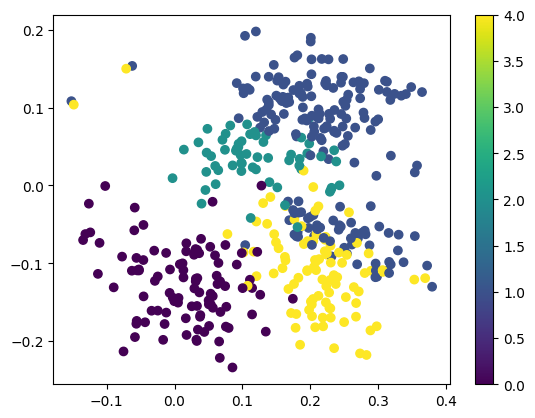

In [16]:
# Encode the data into the latent space
model.eval()
with torch.no_grad():
    encoded_data, labels = [], []
    for batch in dataloader:
        x = batch['data'].float()
        mu, _ = model.encoder(x)
        encoded_data.append(mu)
        labels.append(batch['labels'])
    encoded_data = torch.cat(encoded_data, dim=0)
    labels = torch.cat(labels, dim=0)

# Plot the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels)
plt.colorbar()
plt.show()

In [17]:
with torch.no_grad():
    z, _ = model.encoder(data.float())

In [18]:

# Define the data and labels for each class
class_data = z
class_labels = labels

def find_nearest_neighbors(x, z, k=1):
    """
    Finds the k nearest neighbors to x in the full latent space z.

    Args:
        x (torch.Tensor): A tensor representing the point from class 1.
        z (torch.Tensor): A tensor of data from the full latent space.
        k (int): Number of neighbors to return.

    Returns:
        torch.Tensor: A tensor of k nearest neighbors to x in z.
    """
    # Calculate distances between x and z
    distances = torch.cdist(x, z)

    # Find the k nearest neighbors
    _, indices = torch.topk(distances, k=k)

    # Return the k nearest neighbors
    return z[indices]



In [19]:
def counterfactual_optimization(class_1_data, other_classes_data, k=1, num_iters=1000, lr=0.01):
    """
    Performs counterfactual optimization on a random point from class 1 to find the nearest point in
    another class.

    Args:
        class_1_data (torch.Tensor): A tensor of data from class 1.
        other_classes_data (torch.Tensor): A tensor of data from all other classes.
        k (int): Number of neighbors to consider when finding the nearest neighbor.
        num_iters (int): Number of optimization iterations.
        lr (float): Learning rate for optimization.

    Returns:
        torch.Tensor: A tensor representing the optimized point.
    """

    # Find the nearest neighbor in another class
    nearest_neighbor = find_nearest_neighbors(class_1_data, other_classes_data, k=k)

    # Define the optimization problem
    def loss_fn(z):
        return torch.dist(z, nearest_neighbor)

    # Initialize the optimized point
    z = torch.randn((1, 8), requires_grad=True)

    # Perform optimization
    optimizer = torch.optim.Adam([z], lr=lr)
    for i in range(num_iters):
        optimizer.zero_grad()
        loss = loss_fn(z)
        loss.backward()
        optimizer.step()

    # Return the optimized point from other_classes_data
    distances = torch.norm(other_classes_data - z, dim=1)
    _, min_index = torch.min(distances, dim=0)
    return other_classes_data[min_index]

In [20]:
# Create a mask to filter out samples that are not in class 1
mask = (class_labels != 1).squeeze()

# Select samples from latent space that are not in class 1
latent_space_not_healthy = class_data[mask]

# Print shape of the new tensor
print(latent_space_not_healthy.shape)

torch.Size([250, 8])


In [21]:
class_1_indices = torch.where(class_labels == 1)[0]  # Get the indices of all samples in class 1
random_index = torch.randint(high=class_1_indices.shape[0], size=(1,))  # Choose a random index
random_point_healthy = class_data[class_1_indices[random_index], :]  # Get the random point
random_point_healthy

tensor([[ 0.0987,  0.0567, -0.2355, -0.3114,  0.0844,  0.0343,  0.2172,  0.0629]])

In [22]:
# Find the nearest point in another class
x_cf = counterfactual_optimization(random_point_healthy, latent_space_not_healthy, k=1, num_iters=1000, lr=0.001)
x_cf

tensor([0.3568, 0.0255, 0.1426, 0.3290, 0.1186, 0.2463, 0.5640, 0.2684])

In [65]:
import torch

def shortest_path(z, x, y):
    # Initialize starting variables
    n = z.shape[0]
    dists = torch.full((n,), float('inf'), device=z.device)
    dists[x.long()] = 0
    visited = []
    path = []
    current = x.long()

    # Dijkstra's algorithm
    while current != y.long():
        visited.append(current)
        neighbors = torch.where(z[current] != float('inf'))[0]
        for neighbor in neighbors:
            if neighbor not in visited:
                alt = dists[current] + z[current, neighbor]
                if alt < dists[neighbor]:
                    dists[neighbor] = alt
                    path.append((current, neighbor))
        if len(visited) == n:
            break
        dists[torch.squeeze(torch.tensor(visited))] = float('inf')
        current = torch.argmin(dists)

    # Reconstruct path
    path.append((current, y))
    final_path = []
    while path[-1][0] != x:
        for i in range(len(path)-1, -1, -1):
            if path[i][1] == current:
                final_path.append(current)
                current = path[i][0]
                path.pop(i)
                break
    final_path.append(x)
    final_path.reverse()

    return final_path


In [61]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Euclidian(z, x, y):
    """
    Finds the shortest path between points x and y in the latent space z by using Dijkstra's algorithm.

    Args:
        z (torch.Tensor): A tensor representing the latent space.
        x (torch.Tensor): A tensor representing the starting point.
        y (torch.Tensor): A tensor representing the ending point.

    Returns:
        torch.Tensor: A tensor representing the shortest path between x and y.
    """
    # Compute distances between all points in z
    dist = torch.cdist(z, z, p=2)

    # Find indices of x and y in z
    x_index = torch.where(torch.all(z == x, dim=1))[0]
    y_index = torch.where(torch.all(z == y, dim=1))[0]

    # Initialize distances and visited nodes
    num_nodes = z.shape[0]
    dists = torch.full((num_nodes,), float('inf'))
    visited = torch.zeros((num_nodes,), dtype=torch.bool)

    # Set distance to starting node to 0
    dists[x_index] = 0

    # Initialize previous node array
    prev = torch.full((num_nodes,), -1)

    # Run Dijkstra's algorithm
    for i in range(num_nodes):
        # Find the node with the smallest distance
        min_dist, min_index = torch.min(dists[~visited], dim=0)
        if torch.isinf(min_dist):
            break

        # Mark the node as visited
        visited[min_index] = True

        # Update distances to neighboring nodes
        for j in range(num_nodes):
            if not visited[j]:
                new_dist = dist[min_index, j] + dists[min_index]
                if new_dist < dists[j]:
                    dists[j] = new_dist
                    prev[j] = min_index

    # Follow the path from y to x
    path = [int(y_index)]
    while path[-1] != int(x_index):
        path.append(int(prev[path[-1]]))
    path.reverse()

    # Get tensors corresponding to indices
    line = z[path]


    # Return the shortest path
    return line


In [66]:
x_index = torch.where(torch.all(z == random_point_healthy, dim=1))[0][0].item()
x_index = torch.tensor(x_index)
y_index = torch.where(torch.all(z == x_cf, dim=1))[0][0].item()
y_index  = torch.tensor(y_index)
a = shortest_path(z,random_point_healthy,x_cf)
a


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [59]:
torch.randn(8)

tensor([ 0.0977,  0.1934, -0.1854,  0.6939, -1.6494,  0.1988, -0.2193,  0.5264])

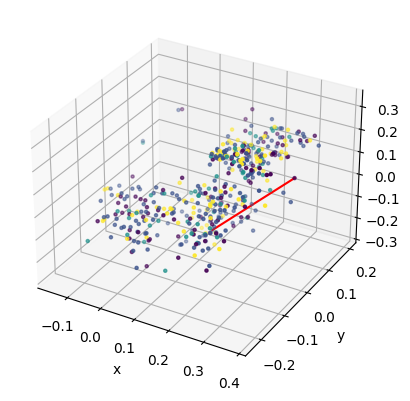

In [37]:
# Assuming x and y are tensors of shape (1, 8) representing random point from class 1 and nearest point in class 2 respectively
# and z is the full latent space tensor of shape (n_samples, 8)

# Get indices of x and y in z
x_index = torch.where(torch.all(z == random_point_healthy, dim=1))[0].item()
y_index = torch.where(torch.all(z == x_cf, dim=1))[0].item()

# Get all indices between x and y in z Using  dijkstra algorith
line = shortest_path(z,random_point_healthy, x_cf)


# Plot line in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(line[:, 0], line[:, 1], line[:, 2],color='red')
# Plot scatter plot
ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=labels, s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [38]:
# Load  latent space and label datasets

with torch.no_grad():
    z, _ = model.encoder(data.float())
latent_space = z

# Find the indices of the data points in your latent space where the labels are 1
random_healthy = np.where(labels == 1)[0]


# Use the `random.choice()` function from NumPy to choose a random index from the indices of the data points where the labels are 1
random_Healthy = np.random.choice(random_healthy)

# Use the chosen index to get the corresponding data point from your latent space
random_H = latent_space[random_Healthy]



In [68]:
# Import dataset and classes needed in this example:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from itertools import product

# Import Gaussian Naive Bayes classifier:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [39]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=5)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

NameError: name 'GaussianNB' is not defined

In [70]:
# Split dataset into random train and test subsets:
train, test, train_labels, test_labels = train_test_split(compined, labels, test_size=0.2, random_state=11)

# Initialize classifier:
gnb = GaussianNB()

# Train the classifier:
classifier = gnb.fit(train, train_labels)
# Make predictions with the classifier:
predictive_labels = gnb.predict(test)
print(predictive_labels)

# Evaluate label (subsets) accuracy:
print(accuracy_score(test_labels, predictive_labels))

[1 1 3 4 3 4 4 3 4 0 1 1 1 1 4 1 1 0 0 0 2 4 1 1 4 1 1 1 1 1 1 1 1 2 4 1 4
 1 3 0 1 1 0 0 4 0 3 3 1 2 1 3 1 1 1 4 1 1 0 1 0 1 1 0 1 1 0 1 0 4 0 4 1 2
 4 1 1 3 1 1 4 1 1 1 1 4 3 4 1 3 4 3 0 2 3 4 2 3 2 1 1 1 1 2 0 1 1 4 1 1 1
 1 3 3 1 1 4 0 1 3 1 1 1 1 2 1 1 1]
0.9921875


/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(compined, labels)
# Evaluate the classifier on the validation set
y_val_pred = clf.predict(test)
val_accuracy = accuracy_score(test_labels, y_val_pred)
val_confusion_matrix = confusion_matrix(test_labels, y_val_pred)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Validation confusion matrix:\n{val_confusion_matrix}")

Validation accuracy: 1.0000
Validation confusion matrix:
[[17  0  0  0  0]
 [ 0 66  0  0  0]
 [ 0  0  9  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 21]]
